In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import requests
import logging
import random
import json
import os
import io

In [2]:
# settings
base_path = os.path.dirname(os.path.abspath(__name__))
plt.rcParams['figure.figsize'] = (20, 3)
plt.style.use('ggplot')
pd.set_option("display.max_columns", None)

In [3]:
def get_ultima_rodada(df):
    """
    Obtém a última rodada de cada temporada e adiciona ao dataframe.
    
    Args:
        df (pandas.DataFrame): DataFrame contendo os dados do campeonato.
    
    Returns:
        pandas.DataFrame: DataFrame com a coluna 'ultima_rodada' adicionada.
    """
    df_max_rodada = df[['temporada', 'rodada']].drop_duplicates().groupby('temporada', as_index=False)['rodada'].max()
    df_max_rodada.rename(columns={'rodada': 'ultima_rodada'}, inplace=True)

    return pd.merge(df, df_max_rodada, how='left', on='temporada')

def get_campeao(df):
    """
    Obtém as informações do time campeão de cada temporada e adiciona ao dataframe.
    
    Args:
        df (pandas.DataFrame): DataFrame contendo os dados do campeonato.
    
    Returns:
        pandas.DataFrame: DataFrame com a coluna 'campeao' adicionada.
    """
    df_campeao = df[df['rodada'] == df['ultima_rodada']].query('posicao == 1')[['time', 'temporada', 'posicao']]
    df_campeao.rename(columns={'posicao': 'campeao'}, inplace=True)
    df_campeao = df_campeao[df_campeao['temporada'] != datetime.now().year]

    df_campeao.groupby('time')['campeao'].sum().sort_values(ascending=False)

    df = pd.merge(df, df_campeao, how='left', on=['time', 'temporada'])
    df.fillna({'campeao': 0}, inplace=True)

    return df

def get_rebaixamento(df):
    """
    Obtém as informações dos times rebaixados em cada temporada e adiciona ao dataframe.
    
    Args:
        df (pandas.DataFrame): DataFrame contendo os dados do campeonato.
    
    Returns:
        pandas.DataFrame: DataFrame com as colunas 'z4_1_anos', 'z4_2_anos' e 'z4_3_anos' adicionadas.
    """
    for i in range(1, 4):
        df_z4 = df[df['rodada'] == df['ultima_rodada']].groupby('temporada').tail(4)[['time', 'temporada']]
        df_z4['temporada'] = df_z4['temporada'] + (1 + i)
        df_z4[f'z4_{i}_anos'] = 1
        df = pd.merge(df, df_z4, how='left', on=['time', 'temporada'])
        df.fillna({f'z4_{i}_anos': 0}, inplace=True)
    
    return df

In [4]:
response = requests.get('https://fnt-campeonato-bra.azurewebsites.net/api/getwf?code=Cw5nnWHZlyyzpHzgIUiX48NiEX3z-rpr0tJpSAxXYDokAzFu4welWQ==')
df = pd.DataFrame(response.json())

In [5]:
# Criando novas variáveis para analise
df = get_ultima_rodada(df)
df = get_campeao(df)
df = get_rebaixamento(df)

# Primeira Validação
dataset = df[['temporada', 'rodada']].drop_duplicates()
df_check = dataset[['temporada', 'rodada']].drop_duplicates().groupby('temporada', as_index=False)['rodada'].count()

anos_completos = pd.DataFrame({'temporada': range(2003, datetime.now().year+1)})

df_check = pd.merge(anos_completos, df_check, on='temporada', how='left')
df_check['rodada'].fillna(0, inplace=True)

# Segunda validação
dataset = df[['temporada', 'time']].drop_duplicates()
df_check_02 = dataset[['temporada', 'time']].drop_duplicates().groupby('temporada', as_index=False)['time'].count()


# Ultima rodada de todas as temporadas
df_ultima_rodada = df[df['rodada'] == df['ultima_rodada']]

# Times
times = df_ultima_rodada.time.drop_duplicates().sort_values().to_list()

# Counts dos times
counts = df_ultima_rodada['time'].value_counts().sort_values(ascending=True).to_frame().reset_index().rename(columns={'count':'qtd'}).copy()

# Estatísticas dos campeões por temporada
estatisticas_campeoes = df_ultima_rodada.query('campeao == 1').groupby('temporada').agg({'pontos': ['max'], 'gols': 'sum'})

# Extraindo os valores para o gráfico
temporadas = estatisticas_campeoes.index
pontos_maximos = estatisticas_campeoes[('pontos', 'max')]
gols_totais = estatisticas_campeoes[('gols', 'sum')]

In [6]:
def plot_temporadas(df, x, y, ponto=None):
    # Criar gráfico de barras
    plt.bar(df[x], df[y], color='skyblue', align='center')

    if ponto:
        plt.axhline(y=38, color='gray', linestyle='--', label='Limite de 38 jogos')  # Adicionando linha horizontal
        for i, valor in enumerate(df[y]):
            if (valor < 38) and (df[x].iloc[i] != datetime.now().year):
                plt.text(df[x].iloc[i], valor + 0.2, str(valor), ha='center', va='bottom')
                plt.axhline(y=valor, color='red', linestyle='-')
            if (df[x].iloc[i] == datetime.now().year):
                plt.text(df[x].iloc[i], valor + 0.2, str(valor), ha='center', va='bottom')

    plt.title(f'Range de {x.title()}')
    plt.xlabel(x.title())
    plt.ylabel(y.title())
    plt.xticks(df[x])
    plt.show()

def plot_temporadas(df, x, y, ponto=None):
    # Criar gráfico de barras
    plt.bar(df[x], df[y], color='skyblue', align='center')

    if ponto:
        plt.axhline(y=38, color='gray', linestyle='--', label='Limite de 38 jogos')  # Adicionando linha horizontal
        for i, valor in enumerate(df[y]):
            if (valor < 38) and (df[x].iloc[i] != datetime.now().year):
                plt.text(df[x].iloc[i], valor + 0.2, str(valor), ha='center', va='bottom')
                plt.axhline(y=valor, color='red', linestyle='-')
            if (df[x].iloc[i] == datetime.now().year):
                plt.text(df[x].iloc[i], valor + 0.2, str(valor), ha='center', va='bottom')

    plt.title(f'Range de {x.title()}')
    plt.xlabel(x.title())
    plt.ylabel(y.title())
    plt.xticks(df[x])
    plt.show()

def plot_analise_gols(contexto):
    # Lista das últimas 9 temporadas
    temporadas = df_ultima_rodada['temporada'].unique()[-9:]

    # Cria uma matriz de subplots 3x3
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 9))

    # Título geral
    fig.suptitle(f"Análise de {' '.join(contexto.split('_'))} por Temporada", fontsize=19)

    # Loop sobre as temporadas e preenche os subplots
    for i, temporada in enumerate(temporadas):
        # Seleciona os dados para a temporada atual
        data_temporada = df_ultima_rodada.query(f'temporada == {temporada}')
        
        # Calcula as métricas desejadas (altere conforme sua necessidade)
        x = data_temporada.groupby('time')['posicao'].max()
        y = data_temporada.groupby('time')[contexto].sum()
        
        # Calcula a posição do subplot na matriz 3x3
        row = i // 3
        col = i % 3
        
        # Plota o gráfico no subplot correspondente
        axes[row, col].scatter(x, y, color='skyblue')
        axes[row, col].set_title(f'{temporada}', fontsize=12)
        axes[row, col].set_xlabel('Posicao')
        axes[row, col].set_ylabel(f"{' '.join(contexto.split('_'))}")

    # Ajusta o layout para evitar sobreposições
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adiciona espaço para o título geral
    plt.show()

def plotar_estatisticas_campeoes(temporadas, pontos_maximos, gols_totais):
    # Criando o gráfico de barras
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()  # Criando um eixo secundário para a linha

    # Plotando as barras de pontos
    ax1.bar(temporadas, pontos_maximos, label='Pontos Máximos', color='skyblue')

    # Plotando a linha de gols
    ax2.plot(temporadas, gols_totais, label='Gols Totais', color='blue', marker='o')

    # Definindo as legendas
    ax1.set_xlabel('Temporada')
    ax1.set_ylabel('Pontos Máximos', color='skyblue')
    ax2.set_ylabel('Gols Totais', color='blue')
    ax1.set_title('Estatísticas dos Campeões por Temporada')

    # Ajustando as temporadas
    ax1.set_xticks(temporadas[::2])
    ax1.set_xticklabels(temporadas[::2])

    # Definindo o limite máximo do eixo secundário
    ax2.set_ylim(bottom=0, top=max(gols_totais) * 1.1)  # Aumente o multiplicador se necessário

    # Configurando o espaçamento
    fig.tight_layout()

    # Exibindo o gráfico
    plt.show()


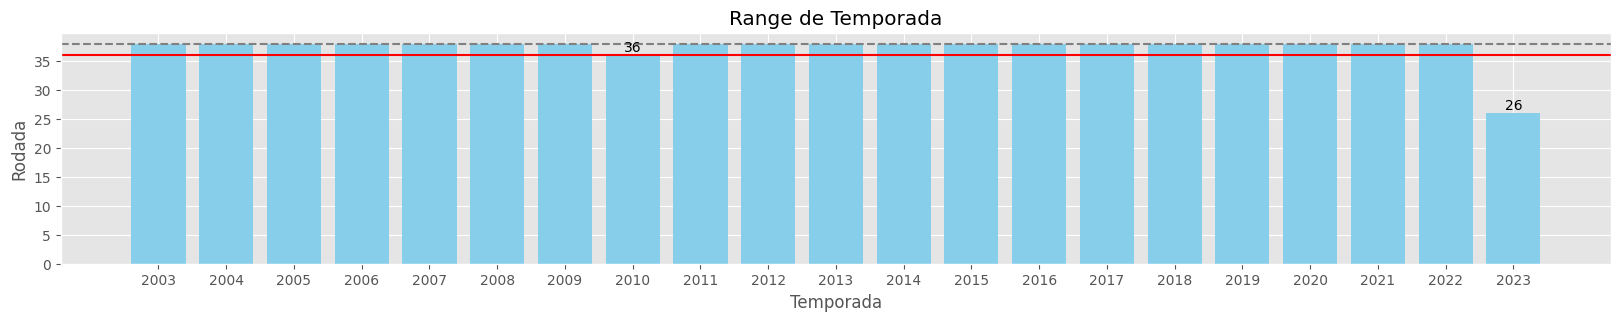

In [7]:
plot_temporadas(df_check, x='temporada', y='rodada', ponto=38)

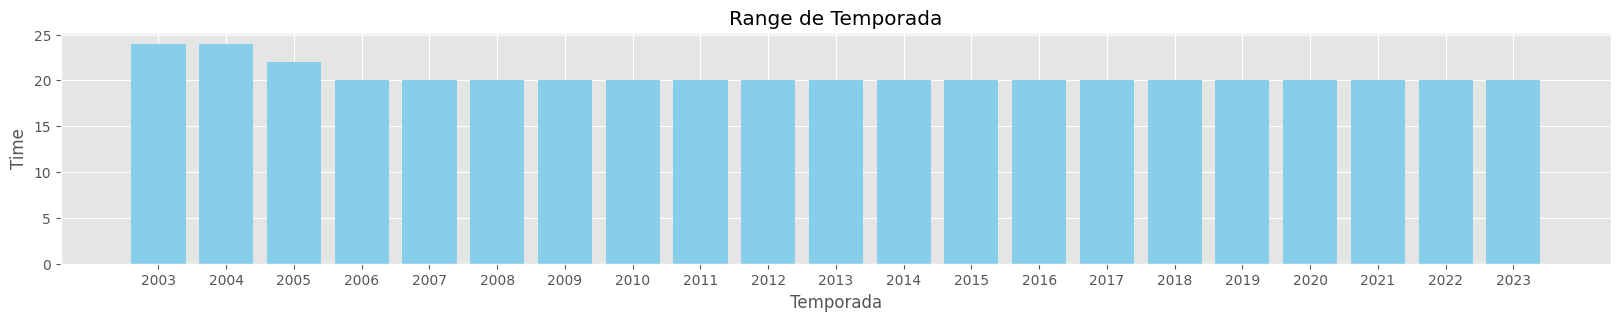

In [8]:
plot_temporadas(df_check_02, x='temporada', y='time')

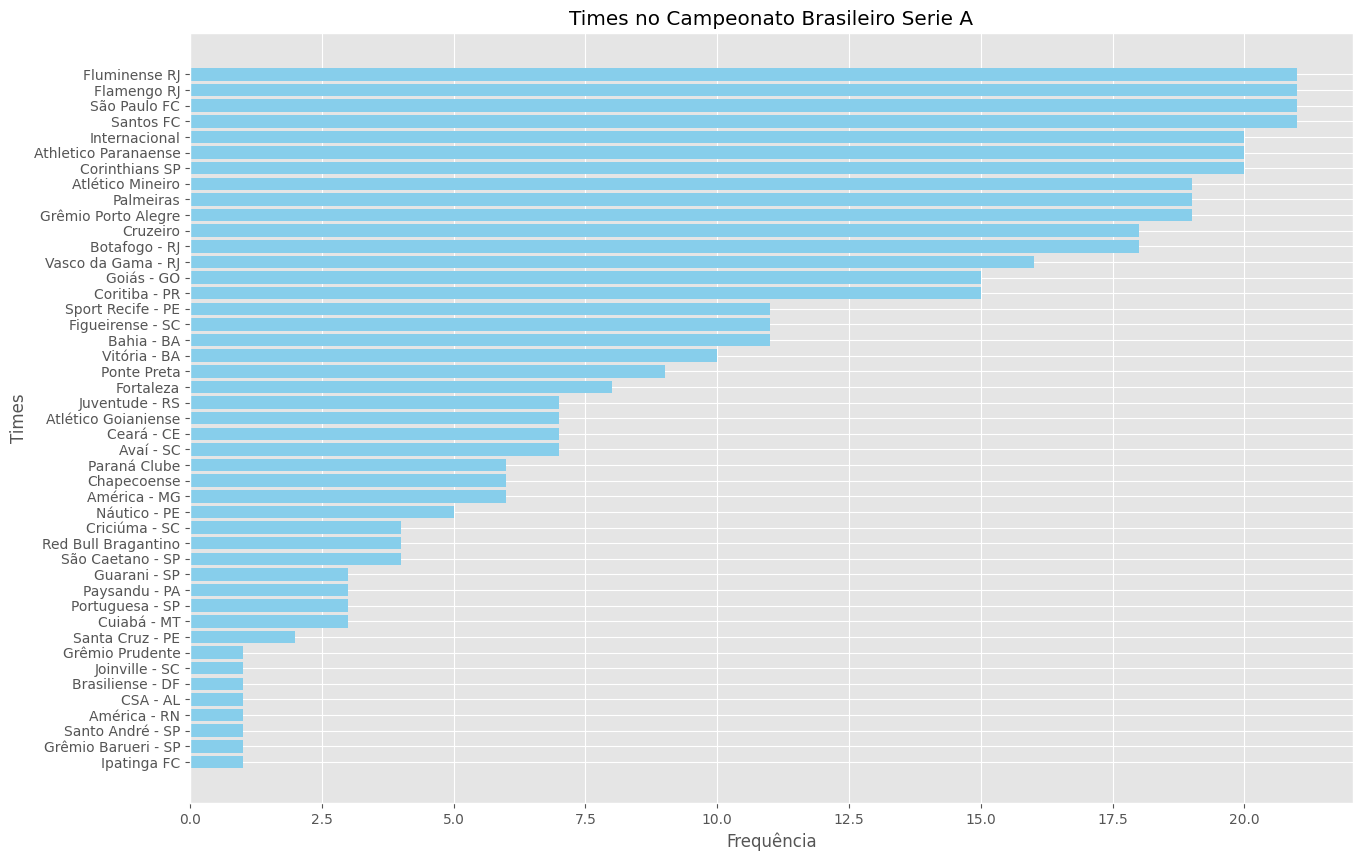

In [9]:
plt.figure(figsize=(15, 10))
plt.barh(counts[counts.columns[0]], counts[counts.columns[1]], color='skyblue')
plt.xlabel('Frequência')
plt.ylabel('Times')
plt.title('Times no Campeonato Brasileiro Serie A')
plt.show()

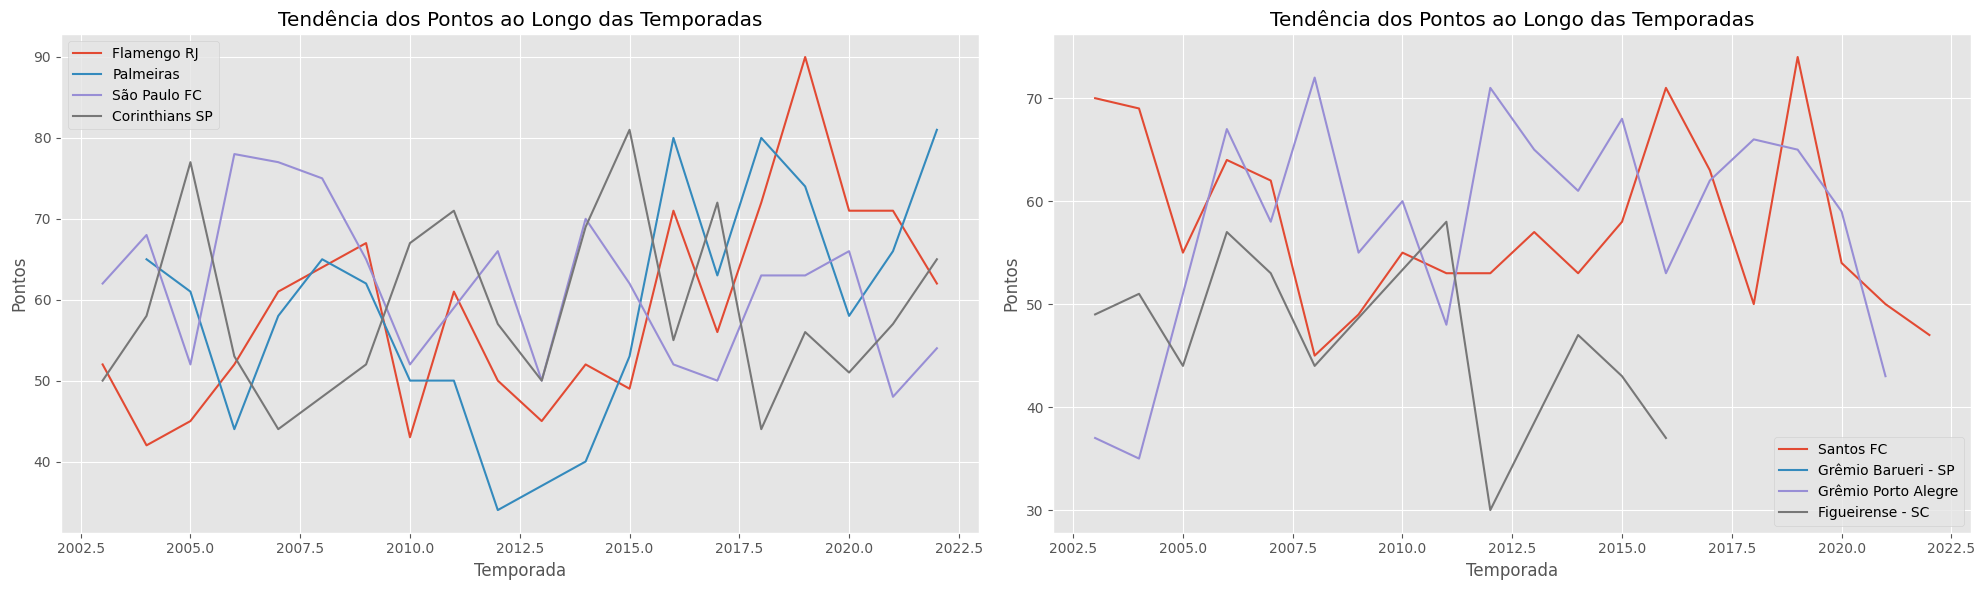

In [10]:
# Visualizar a tendência dos pontos ao longo das temporadas para alguns times selecionados
df_grouped = df_ultima_rodada[df_ultima_rodada['temporada'] != 2023].groupby(['time', 'temporada']).agg({'pontos': 'sum'}).reset_index()
times_selecionados = ['Flamengo RJ', 'Palmeiras', 'São Paulo FC', 'Corinthians SP']
df_times_selecionados = df_grouped[df_grouped['time'].isin(times_selecionados)]

# Primeiro gráfico
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
for time in times_selecionados:
    df_time = df_times_selecionados[df_times_selecionados['time'] == time]
    plt.plot(df_time['temporada'], df_time['pontos'], label=time)
plt.xlabel('Temporada')
plt.ylabel('Pontos')
plt.title('Tendência dos Pontos ao Longo das Temporadas')
plt.legend()

# Segundo gráfico
plt.subplot(1, 2, 2)
random.shuffle(times)
times_selecionados_aleatorio = times[:4]
df_times_selecionados_aleatorio = df_grouped[df_grouped['time'].isin(times_selecionados_aleatorio)]

for time in times_selecionados_aleatorio:
    df_time = df_times_selecionados_aleatorio[df_times_selecionados_aleatorio['time'] == time]
    plt.plot(df_time['temporada'], df_time['pontos'], label=time)
plt.xlabel('Temporada')
plt.ylabel('Pontos')
plt.title('Tendência dos Pontos ao Longo das Temporadas')
plt.legend()

plt.tight_layout()
plt.show()

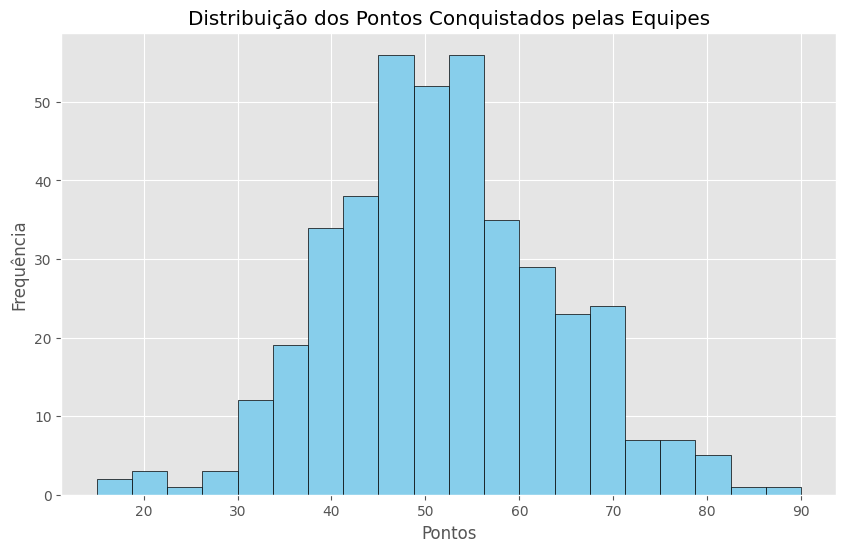

In [11]:
# Distribuição dos pontos conquistados pelas equipes
plt.figure(figsize=(10, 6))
plt.hist(df_grouped['pontos'], bins=20, edgecolor='k', color='skyblue')
plt.xlabel('Pontos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Pontos Conquistados pelas Equipes')
plt.show()

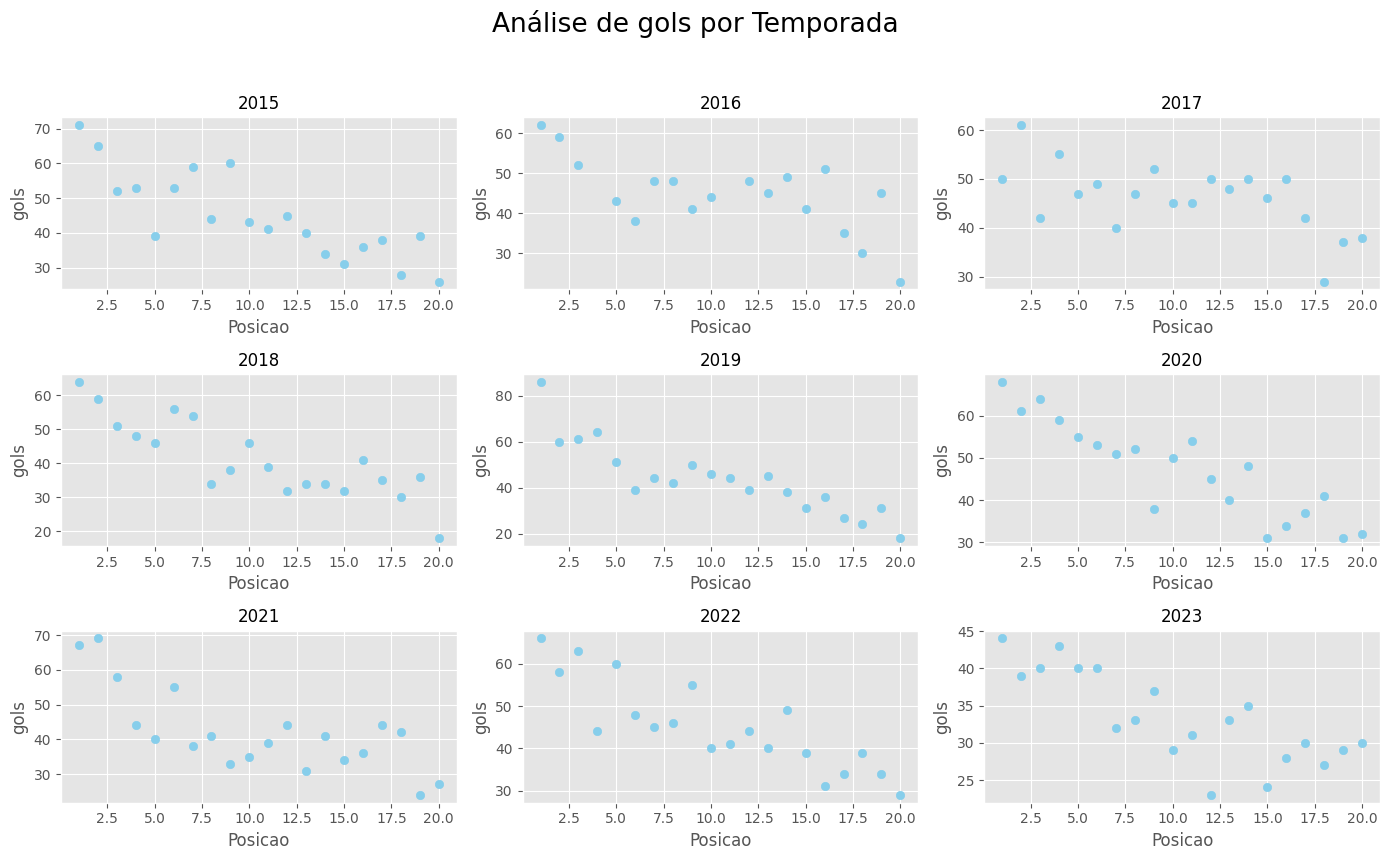

In [12]:
plot_analise_gols('gols')

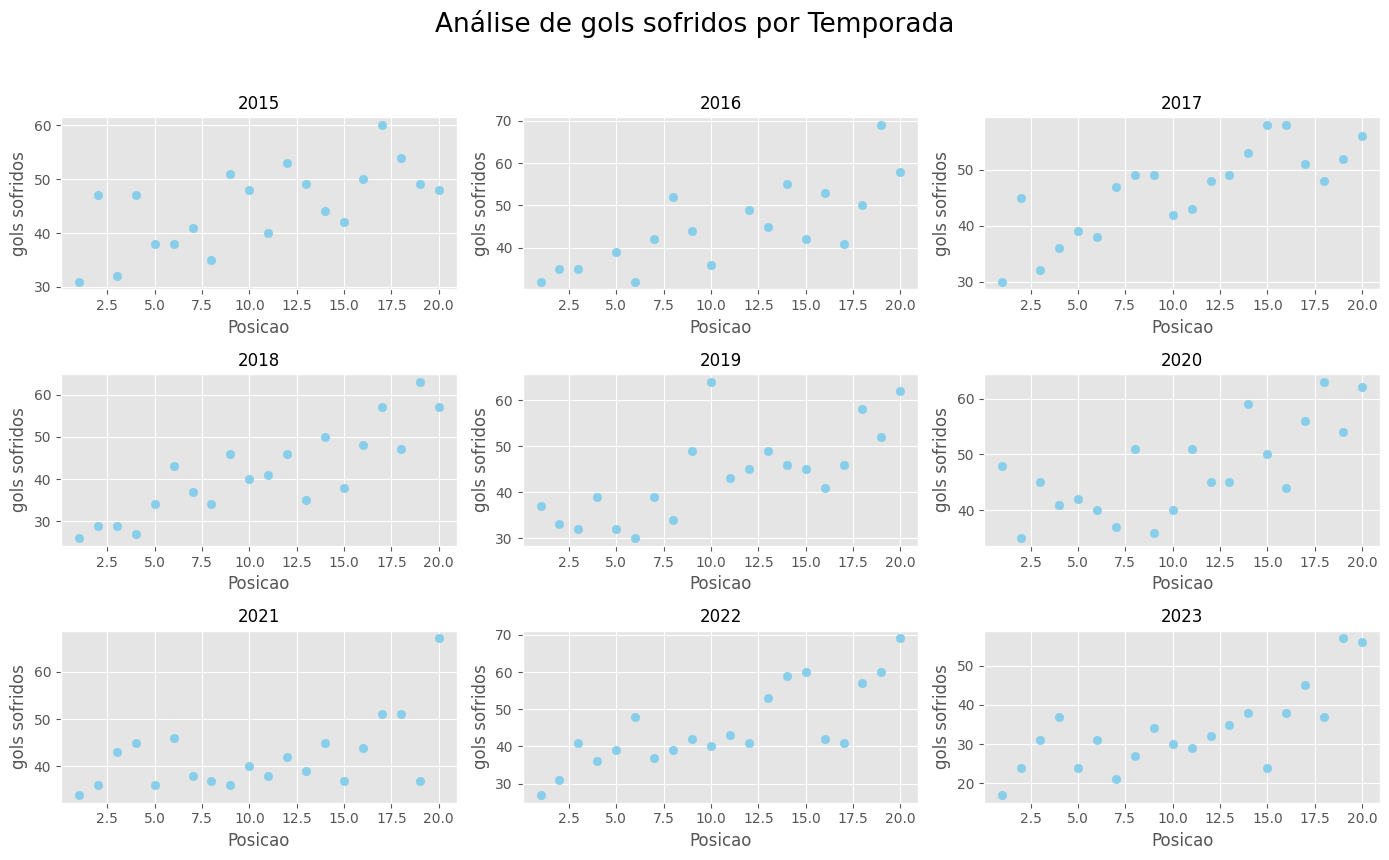

In [13]:
plot_analise_gols('gols_sofridos')

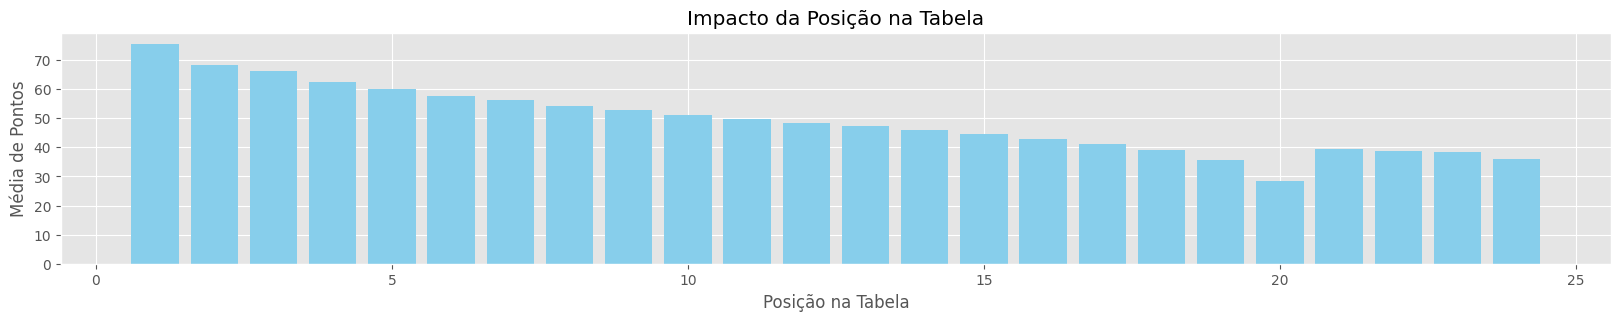

In [14]:
# Média de pontos por posição na tabela
media_pontos_posicao = df_ultima_rodada.groupby('posicao')['pontos'].mean()

# Gráfico de barras mostrando a média de pontos por posição na tabela
plt.bar(media_pontos_posicao.index, media_pontos_posicao.values, color='skyblue')
plt.xlabel('Posição na Tabela')
plt.ylabel('Média de Pontos')
plt.title('Impacto da Posição na Tabela')
plt.show()

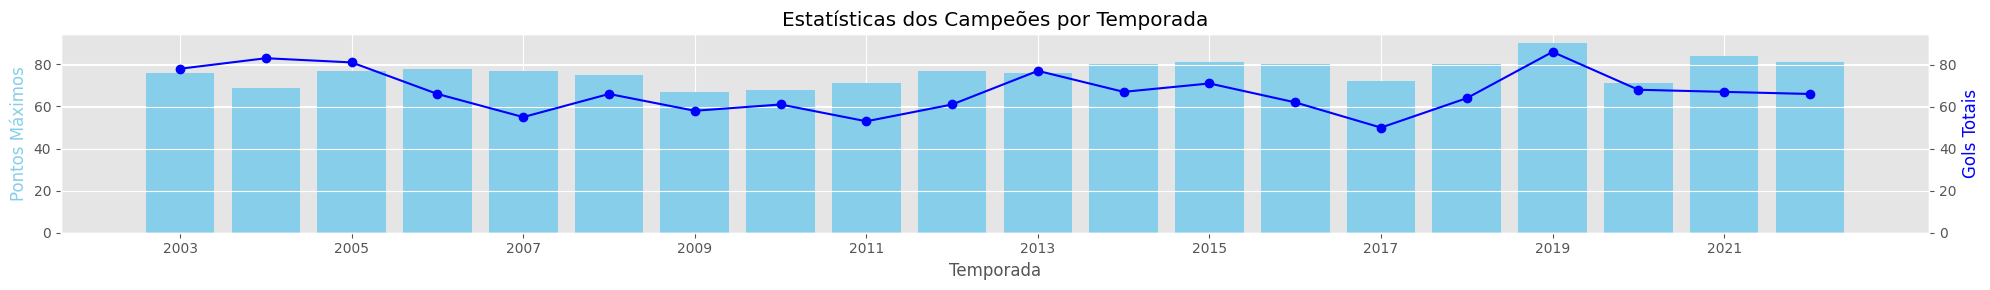

In [15]:
# Chamando a função para gerar o gráfico
plotar_estatisticas_campeoes(temporadas, pontos_maximos, gols_totais)

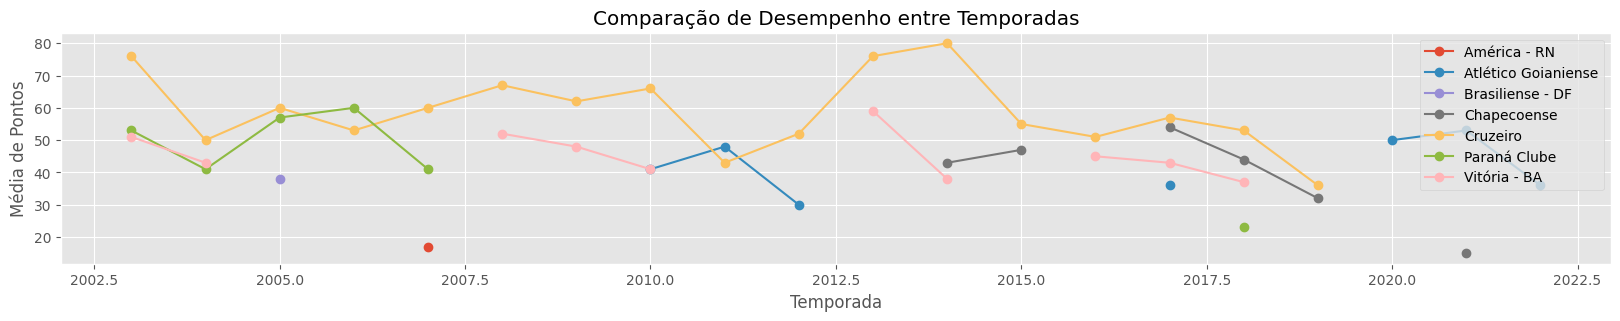

In [16]:
# Média de pontos por temporada para cada equipe
random.shuffle(times)
times_red = times[:7]
media_pontos_temporada_equipe = df_ultima_rodada[df_ultima_rodada['time'].isin(times_red)].query("temporada != 2023").groupby(['temporada', 'time'])['pontos'].mean().unstack()

# Gráfico de linha comparando o desempenho das equipes ao longo das temporadas
media_pontos_temporada_equipe.plot(marker='o')
plt.xlabel('Temporada')
plt.ylabel('Média de Pontos')
plt.title('Comparação de Desempenho entre Temporadas')
plt.legend(loc='upper right')
plt.show()

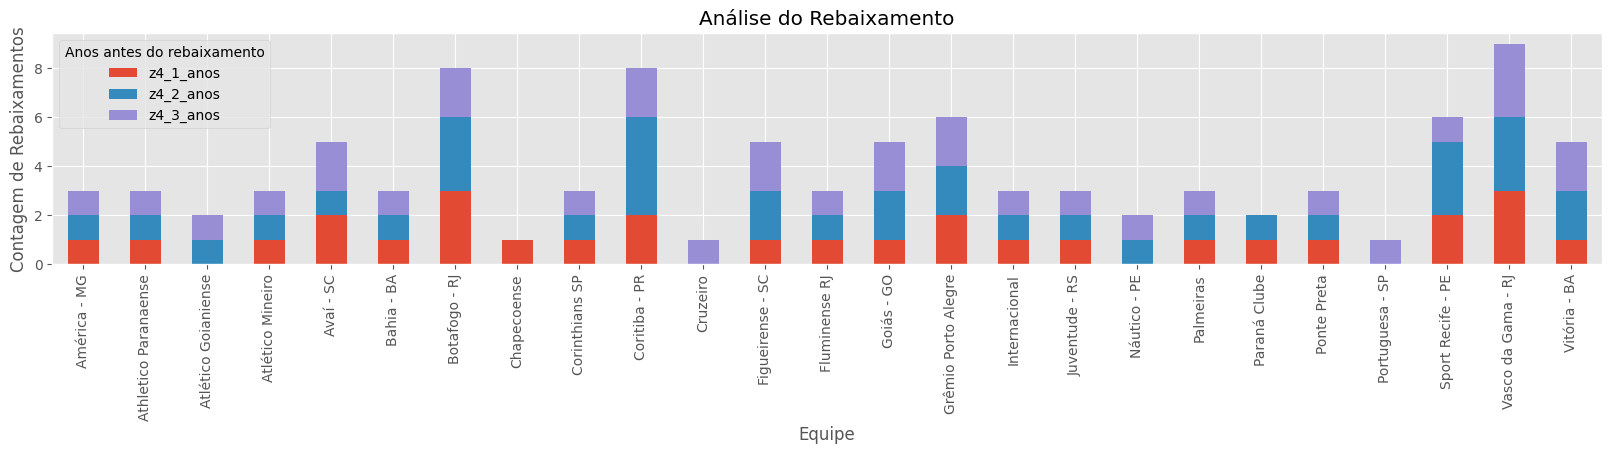

In [17]:
# Contagem de vezes em que cada equipe ficou na zona de rebaixamento
contagem_rebaixamento = df_ultima_rodada.groupby('time')[['z4_1_anos', 'z4_2_anos', 'z4_3_anos']].sum()
# Verifique se todas as colunas 'z4' são iguais a zero
mask = (contagem_rebaixamento[['z4_1_anos', 'z4_2_anos', 'z4_3_anos']] != 0).any(axis=1)
contagem_rebaixamento = contagem_rebaixamento[mask]

# Gráfico de barras mostrando a contagem de rebaixamentos por equipe
contagem_rebaixamento.plot(kind='bar', stacked=True)
plt.xlabel('Equipe')
plt.ylabel('Contagem de Rebaixamentos')
plt.title('Análise do Rebaixamento')
plt.legend(title='Anos antes do rebaixamento')
plt.show()

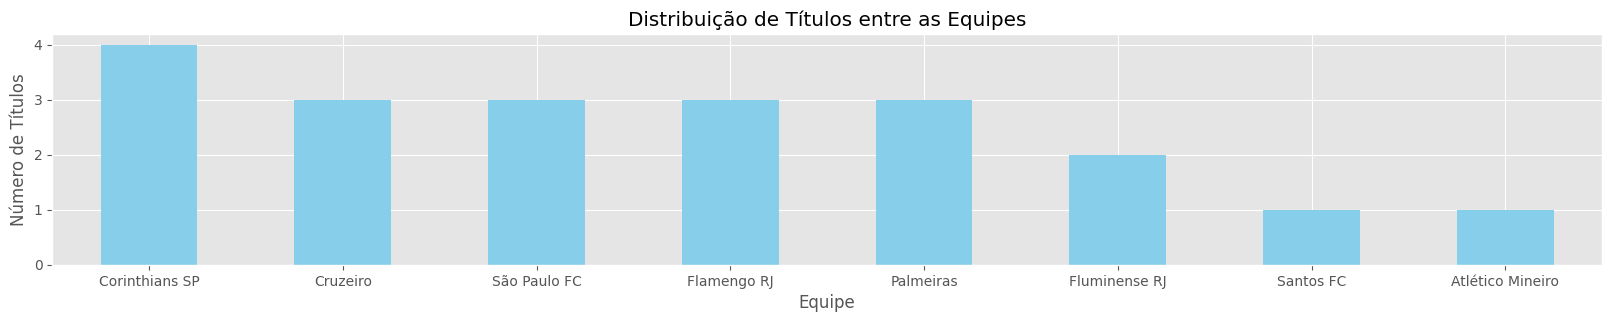

In [18]:
# Contagem de títulos por equipe
contagem_titulos = df_ultima_rodada.query('campeao == 1')['time'].value_counts()

# Gráfico de barras mostrando a distribuição de títulos entre as equipes
contagem_titulos.plot(kind='bar', color='skyblue')
plt.xlabel('Equipe')
plt.ylabel('Número de Títulos')
plt.title('Distribuição de Títulos entre as Equipes')
plt.xticks(rotation=0)
plt.show()

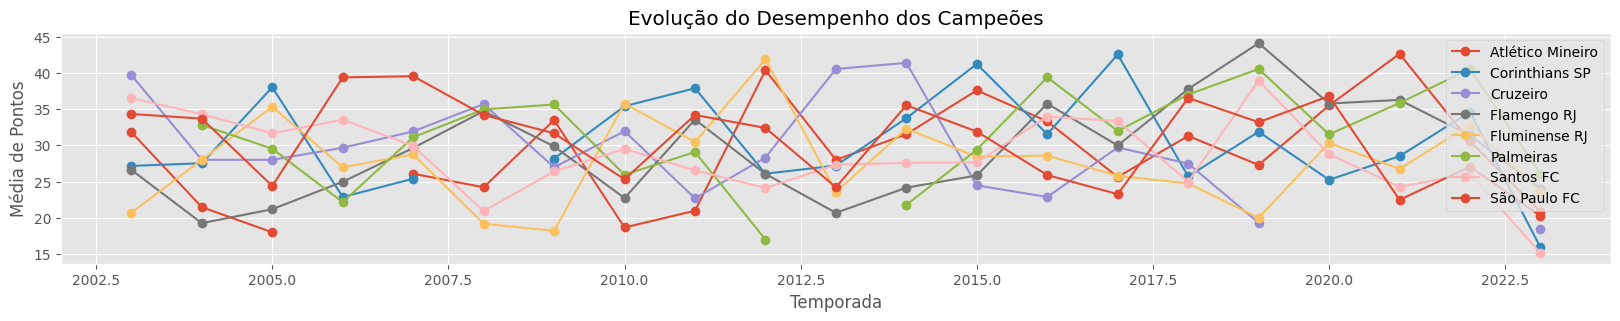

In [19]:
# Média de pontos por temporada para os campeões
media_pontos_temporada_campeoes = df[df['time'].isin(df[df['rodada'] == df['ultima_rodada']].query('campeao == 1')['time'])].groupby(['temporada', 'time'])['pontos'].mean().unstack()

# Gráfico de linha mostrando a evolução do desempenho dos campeões ao longo das temporadas
media_pontos_temporada_campeoes.plot(marker='o')
plt.xlabel('Temporada')
plt.ylabel('Média de Pontos')
plt.title('Evolução do Desempenho dos Campeões')
plt.legend(loc='upper right')
plt.show()